In [55]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [56]:
os.chdir(r"D:\PAU document\Thesis\Analysis\CMIP6 data\MPI_ESM1_2_HR\Future data")
cwd = os.getcwd()
cwd

'D:\\PAU document\\Thesis\\Analysis\\CMIP6 data\\MPI_ESM1_2_HR\\Future data'

In [57]:
#Observed 
#Hist_Raw 
#Hist_Corr
Near_Raw
#Near_Corr
#Mid_Raw 
#Mid_Corr
#Far_Raw 
#Far_Corr

<xarray.Dataset> Size: 356kB
Dimensions:    (time: 780, lat: 8, lon: 7)
Coordinates:
  * time       (time) datetime64[ns] 6kB 1950-01-01 1950-02-01 ... 2014-12-01
  * lat        (lat) float64 64B 10.77 11.08 11.4 11.71 12.02 12.33 12.64 12.96
  * lon        (lon) float64 56B 36.56 36.88 37.19 37.5 37.81 38.12 38.44
Data variables:
    pr_interp  (time, lat, lon) float64 349kB ...

In [86]:
# ======== FONT SETTINGS ========
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.weight"] = "bold"  # Make all text bold

In [87]:
# ======== FILES & SETTINGS ========
files_vars = {
    "Observed":("D:\\PAU document\\Thesis\\Analysis\\Row Data\\pr_Lake_tana_19830101_20131231_month.nc", "pr"),
    "Hist_Raw":("D:\\PAU document\\Thesis\\Analysis\\CMIP6 data\\MPI_ESM1_2_HR\Future data\\Int_pr_MPI_ESM1_2_HR_historical_r1i1p1f1_gn_19500101_20141231_month.nc", "pr_interp"),
    "Hist_Corr":("D:\\PAU document\Thesis\\Analysis\\CMIP6 data\\MPI_ESM1_2_HR\\Historical\\af95baec4a6dbf80f2f75b0441bee7ad\\corr_Int_pr_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_19500101-20141231_month.nc", "pr_corrected"),
    "Near_Raw":("D:\\PAU document\\Thesis\\Analysis\\CMIP6 data\\MPI_ESM1_2_HR\\Future data\\SSP24.5\\Corrected GCM\\Int_pr_month_MPI_ESM1_2_HR_ssp245_r1i1p1f1_gn_20150101_21001231_mm.nc", "pr_interp"),
    "Near_Corr":("D:\\PAU document\\Thesis\\Analysis\\CMIP6 data\\MPI_ESM1_2_HR\\Future data\\SSP24.5\\Corrected GCM\\Int_2_pr_month_MPI-ESM1-2-HR_ssp245_r1i1p1f1_gn_20200101-20491231.nc", "pr_corrected"),
    "Mid_Raw":("D:\\PAU document\\Thesis\\Analysis\\CMIP6 data\\MPI_ESM1_2_HR\\Future data\\SSP24.5\\Corrected GCM\\Int_pr_month_MPI_ESM1_2_HR_ssp245_r1i1p1f1_gn_20150101_21001231_mm.nc", "pr_interp"),
    "Mid_Corr":("D:\\PAU document\\Thesis\\Analysis\\CMIP6 data\\MPI_ESM1_2_HR\\Future data\\SSP24.5\\Corrected GCM\\Int_pr_month_MPI_ESM1_2_HR_ssp245_r1i1p1f1_gn_20410101_20701231.nc", "pr_corrected"),
    "Far_Raw":("D:\\PAU document\\Thesis\\Analysis\\CMIP6 data\\MPI_ESM1_2_HR\\Future data\\SSP24.5\\Corrected GCM\\Int_pr_month_MPI_ESM1_2_HR_ssp245_r1i1p1f1_gn_20150101_21001231_mm.nc", "pr_interp"),
    "Far_Corr":("D:\\PAU document\\Thesis\\Analysis\\CMIP6 data\\MPI_ESM1_2_HR\\Future data\\SSP24.5\\Corrected GCM\\Int_pr_month_MPI_ESM1_2_HR_ssp245_r1i1p1f1_gn_20710101_21001231.nc", "pr_corrected"),
}

time_dim = "time"
output_jpg = r"D:\PAU document\Thesis\Analysis\CMIP6 data\MPI_ESM1_2_HR\Future data\SSP24.5\Corrected GCM\precip_ssp245_metrics_violin.jpg"

In [88]:
for name, (path, _) in files_vars.items():
    if not os.path.isfile(path):
        print(f"❌ Missing file: {name} -> {path}")
    else:
        print(f"✅ Found file: {name}")

✅ Found file: Observed
✅ Found file: Hist_Raw
✅ Found file: Hist_Corr
✅ Found file: Near_Raw
✅ Found file: Near_Corr
✅ Found file: Mid_Raw
✅ Found file: Mid_Corr
✅ Found file: Far_Raw
✅ Found file: Far_Corr


In [89]:
# ======== FUNCTIONS ========
def load_series(path, var, time_dim="time"):
    ds = xr.open_dataset(path)
    da = ds[var]
    extra_dims = [d for d in da.dims if d != time_dim]
    if extra_dims:
        da = da.mean(extra_dims, skipna=True)
    return da.to_series().dropna()

def align_and_stats(ref, arr):
    joined = pd.concat([ref, arr], axis=1, join="inner").dropna()
    if joined.empty:
        return np.nan, np.nan, np.nan, np.nan
    y_true, y_pred = joined.iloc[:, 0], joined.iloc[:, 1]
    r2 = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)
    mse = np.mean((y_true - y_pred)**2)
    pbias = 100 * np.sum(y_pred - y_true) / np.sum(y_true)
    nse = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)
    return r2, mse, pbias, nse

# ======== LOAD DATA ========
datasets = {}
for name, (path, varname) in files_vars.items():
    datasets[name] = load_series(path, varname, time_dim)

In [90]:
# ======== FUNCTIONS ========
def load_series(path, var, time_dim="time"):
    if not os.path.exists(path):
        print(f"❌ Missing file: {path}")
        return pd.Series(dtype=float)
    ds = xr.open_dataset(path)
    da = ds[var]
    extra_dims = [d for d in da.dims if d != time_dim]
    if extra_dims:
        da = da.mean(extra_dims, skipna=True)
    return da.to_series().dropna()

def compute_metrics(y_true, y_pred):
    """Compute R², NSE, MSE, PBIAS, CORR."""
    if len(y_true) == 0 or len(y_pred) == 0:
        return [np.nan] * 5
    r2 = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)
    mse = np.mean((y_true - y_pred)**2)
    pbias = 100 * np.sum(y_pred - y_true) / np.sum(y_true)
    nse = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)
    corr = np.corrcoef(y_true, y_pred)[0, 1] if len(y_true) > 1 else np.nan
    return r2, mse, pbias, nse, corr

def align_and_stats(ref, arr):
    joined = pd.concat([ref, arr], axis=1, join="inner").dropna()
    return compute_metrics(joined.iloc[:, 0], joined.iloc[:, 1])

def monthly_match_and_stats(obs_series, fut_series):
    obs_df = pd.DataFrame({"Value": obs_series, "Month": obs_series.index.month})
    fut_df = pd.DataFrame({"Value": fut_series, "Month": fut_series.index.month})
    month_map = obs_df.groupby("Month")["Value"].mean()
    fut_df["Obs_Mean"] = fut_df["Month"].map(month_map)
    joined = fut_df.dropna()
    return compute_metrics(joined["Obs_Mean"], joined["Value"])

# ======== LOAD DATA ========
datasets = {}
for name, (path, varname) in files_vars.items():
    datasets[name] = load_series(path, varname, time_dim)

In [91]:
# ======== PERIODS ========
periods = {
    "Observed": ("1983-01-01", "2012-12-31"),
    "Hist_Raw": ("1983-01-01", "2012-12-31"),
    "Hist_Corr": ("1983-01-01", "2012-12-31"),
    "Near_Raw": ("2020-01-01", "2049-12-31"),
    "Near_Corr": ("2020-01-01", "2049-12-31"),
    "Mid_Raw": ("2041-01-01", "2070-12-31"),
    "Mid_Corr": ("2041-01-01", "2070-12-31"),
    "Far_Raw": ("2071-01-01", "2100-12-31"),
    "Far_Corr": ("2071-01-01", "2100-12-31"),
}

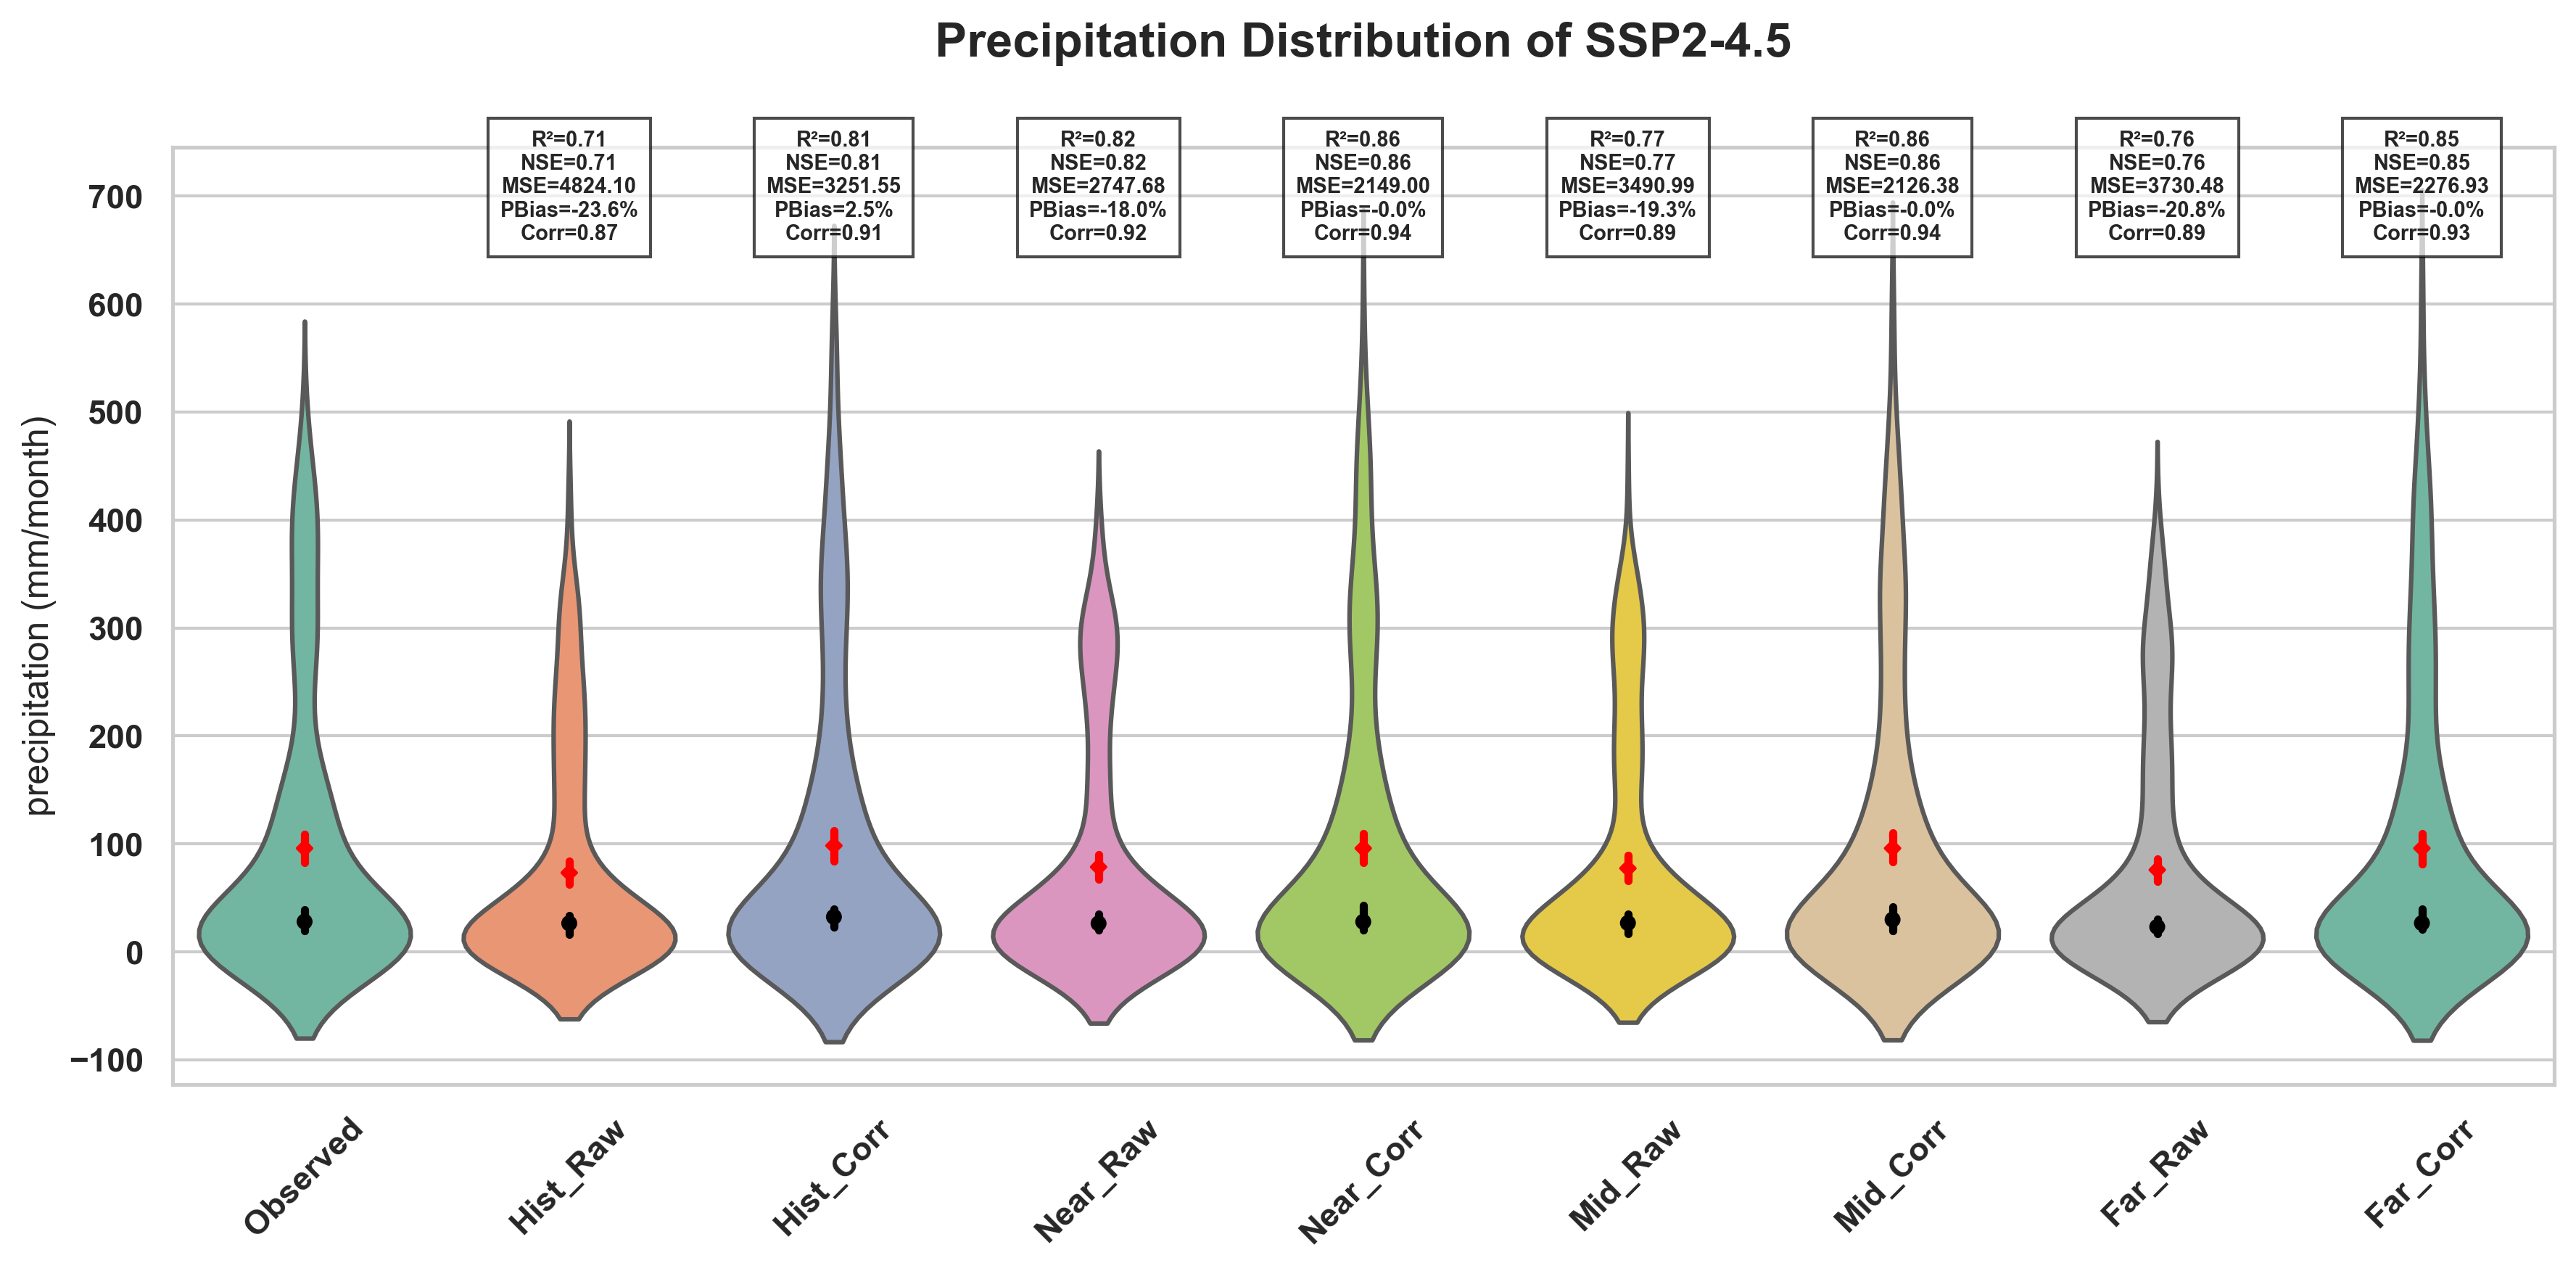

✅ Plot saved to D:\PAU document\Thesis\Analysis\CMIP6 data\MPI_ESM1_2_HR\Future data\SSP24.5\Corrected GCM\precip_ssp245_metrics_violin.jpg


In [93]:
# Slice datasets
for name, (start, end) in periods.items():
    datasets[name] = datasets[name].loc[start:end]

# ======== STATS ========
obs = datasets["Observed"]
stats_df = []
for name, ser in datasets.items():
    if name == "Observed":
        continue
    if "Hist" in name:
        r2, mse, pbias, nse, corr = align_and_stats(obs, ser)
    else:
        r2, mse, pbias, nse, corr = monthly_match_and_stats(obs, ser)
    stats_df.append({
        "Dataset": name,
        "R2": r2, "MSE": mse, "PBIAS": pbias, "NSE": nse, "CORR": corr
    })
stats_df = pd.DataFrame(stats_df)

# ======== LONG DF FOR VIOLIN ========
df_long = pd.concat(datasets, axis=1).melt(var_name="Dataset", value_name="Value").dropna()

# ======== PLOT ========
sns.set(style="whitegrid", font_scale=1)
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

sns.violinplot(
    data=df_long, x="Dataset", y="Value",
    ax=ax, inner=None, scale="width", palette="Set2"
)
sns.pointplot(
    data=df_long, x="Dataset", y="Value",
    ax=ax, join=False, estimator=np.median,
    color="black", markers="o", scale=0.6
)
sns.pointplot(
    data=df_long, x="Dataset", y="Value",
    ax=ax, join=False, estimator=np.mean,
    color="red", markers="D", scale=0.5
)

# Add stats above violins
ymax = df_long["Value"].max()
for i, name in enumerate(df_long["Dataset"].unique()):
    row = stats_df[stats_df["Dataset"] == name]
    if not row.empty:
        s = row.iloc[0]
        text = (
            f"R²={s['R2']:.2f}\n"
            f"NSE={s['NSE']:.2f}\n"
            f"MSE={s['MSE']:.2f}\n"
            f"PBias={s['PBIAS']:.1f}%\n"
            f"Corr={s['CORR']:.2f}"
        )
        ax.text(i, ymax + 0.05*ymax, text,
                ha='center', va='bottom', fontsize=7,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

ax.set_title("Precipitation Distribution of SSP2-4.5", fontsize=16, fontweight='bold', pad=30)
ax.set_xlabel("")
ax.set_ylabel("precipitation (mm/month)")
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(output_jpg, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved to {output_jpg}")


In [109]:
# ======== FILES & SETTINGS ========
files_vars = {
    "Observed":("D:\\PAU document\\Thesis\\Analysis\\Row Data\\pr_Lake_tana_19830101_20131231_month.nc", "pr"),
    "Hist_Raw":("D:\\PAU document\\Thesis\\Analysis\\CMIP6 data\\MPI_ESM1_2_HR\Future data\\Int_pr_MPI_ESM1_2_HR_historical_r1i1p1f1_gn_19500101_20141231_month.nc", "pr_interp"),
    "Hist_Corr":("D:\\PAU document\Thesis\\Analysis\\CMIP6 data\\MPI_ESM1_2_HR\\Historical\\af95baec4a6dbf80f2f75b0441bee7ad\\corr_Int_pr_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_19500101-20141231_month.nc", "pr_corrected"),
    "Near_Raw":("D:\\PAU document\\Thesis\\Analysis\\CMIP6 data\\MPI_ESM1_2_HR\\Future data\\SSP58.5\\Corrected\\Int_pr_month_MPI-ESM1-2-HR_ssp585_r1i1p1f1_gn_20150101-21001231.nc", "pr_interp"),
    "Near_Corr":("D:\\PAU document\\Thesis\\Analysis\\CMIP6 data\\MPI_ESM1_2_HR\\Future data\\SSP58.5\\Corrected\\Int_2_pr_month_MPI-ESM1-2-HR_ssp485_r1i1p1f1_gn_20200101-20491231.nc", "pr_corrected"),
    "Mid_Raw":("D:\\PAU document\\Thesis\\Analysis\\CMIP6 data\\MPI_ESM1_2_HR\\Future data\\SSP58.5\\Corrected\\Int_pr_month_MPI-ESM1-2-HR_ssp585_r1i1p1f1_gn_20150101-21001231.nc", "pr_interp"),
    "Mid_Corr":("D:\\PAU document\\Thesis\\Analysis\\CMIP6 data\\MPI_ESM1_2_HR\\Future data\\SSP58.5\\Corrected\\Int_2_pr_month_MPI-ESM1-2-HR_ssp485_r1i1p1f1_gn_20410101-20701231.nc", "pr_corrected"),
    "Far_Raw":("D:\\PAU document\\Thesis\\Analysis\\CMIP6 data\\MPI_ESM1_2_HR\\Future data\\SSP58.5\\Corrected\\Int_pr_month_MPI-ESM1-2-HR_ssp585_r1i1p1f1_gn_20150101-21001231.nc", "pr_interp"),
    "Far_Corr":("D:\\PAU document\\Thesis\\Analysis\\CMIP6 data\\MPI_ESM1_2_HR\\Future data\\SSP58.5\\Corrected\\Int_2_pr_month_MPI-ESM1-2-HR_ssp485_r1i1p1f1_gn_20710101-21001231.nc", "pr_corrected"),
}

time_dim = "time"
output_jpg = r"D:\PAU document\Thesis\Analysis\CMIP6 data\MPI_ESM1_2_HR\Future data\SSP58.5\Corrected\precip_ssp585_metrics_violin.jpg"

In [110]:
# ======== FUNCTIONS ========
def load_series(path, var, time_dim="time"):
    ds = xr.open_dataset(path)
    da = ds[var]
    extra_dims = [d for d in da.dims if d != time_dim]
    if extra_dims:
        da = da.mean(extra_dims, skipna=True)
    return da.to_series().dropna()

def align_and_stats(ref, arr):
    joined = pd.concat([ref, arr], axis=1, join="inner").dropna()
    if joined.empty:
        return np.nan, np.nan, np.nan, np.nan
    y_true, y_pred = joined.iloc[:, 0], joined.iloc[:, 1]
    r2 = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)
    mse = np.mean((y_true - y_pred)**2)
    pbias = 100 * np.sum(y_pred - y_true) / np.sum(y_true)
    nse = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)
    return r2, mse, pbias, nse

# ======== LOAD DATA ========
datasets = {}
for name, (path, varname) in files_vars.items():
    datasets[name] = load_series(path, varname, time_dim)

In [111]:
# ======== FUNCTIONS ========
def load_series(path, var, time_dim="time"):
    if not os.path.exists(path):
        print(f"❌ Missing file: {path}")
        return pd.Series(dtype=float)
    ds = xr.open_dataset(path)
    da = ds[var]
    extra_dims = [d for d in da.dims if d != time_dim]
    if extra_dims:
        da = da.mean(extra_dims, skipna=True)
    return da.to_series().dropna()

def compute_metrics(y_true, y_pred):
    """Compute R², NSE, MSE, PBIAS, CORR."""
    if len(y_true) == 0 or len(y_pred) == 0:
        return [np.nan] * 5
    r2 = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)
    mse = np.mean((y_true - y_pred)**2)
    pbias = 100 * np.sum(y_pred - y_true) / np.sum(y_true)
    nse = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)
    corr = np.corrcoef(y_true, y_pred)[0, 1] if len(y_true) > 1 else np.nan
    return r2, mse, pbias, nse, corr

def align_and_stats(ref, arr):
    joined = pd.concat([ref, arr], axis=1, join="inner").dropna()
    return compute_metrics(joined.iloc[:, 0], joined.iloc[:, 1])

def monthly_match_and_stats(obs_series, fut_series):
    obs_df = pd.DataFrame({"Value": obs_series, "Month": obs_series.index.month})
    fut_df = pd.DataFrame({"Value": fut_series, "Month": fut_series.index.month})
    month_map = obs_df.groupby("Month")["Value"].mean()
    fut_df["Obs_Mean"] = fut_df["Month"].map(month_map)
    joined = fut_df.dropna()
    return compute_metrics(joined["Obs_Mean"], joined["Value"])

# ======== LOAD DATA ========
datasets = {}
for name, (path, varname) in files_vars.items():
    datasets[name] = load_series(path, varname, time_dim)

In [112]:
# ======== PERIODS ========
periods = {
    "Observed": ("1983-01-01", "2012-12-31"),
    "Hist_Raw": ("1983-01-01", "2012-12-31"),
    "Hist_Corr": ("1983-01-01", "2012-12-31"),
    "Near_Raw": ("2020-01-01", "2049-12-31"),
    "Near_Corr": ("2020-01-01", "2049-12-31"),
    "Mid_Raw": ("2041-01-01", "2070-12-31"),
    "Mid_Corr": ("2041-01-01", "2070-12-31"),
    "Far_Raw": ("2071-01-01", "2100-12-31"),
    "Far_Corr": ("2071-01-01", "2100-12-31"),
}

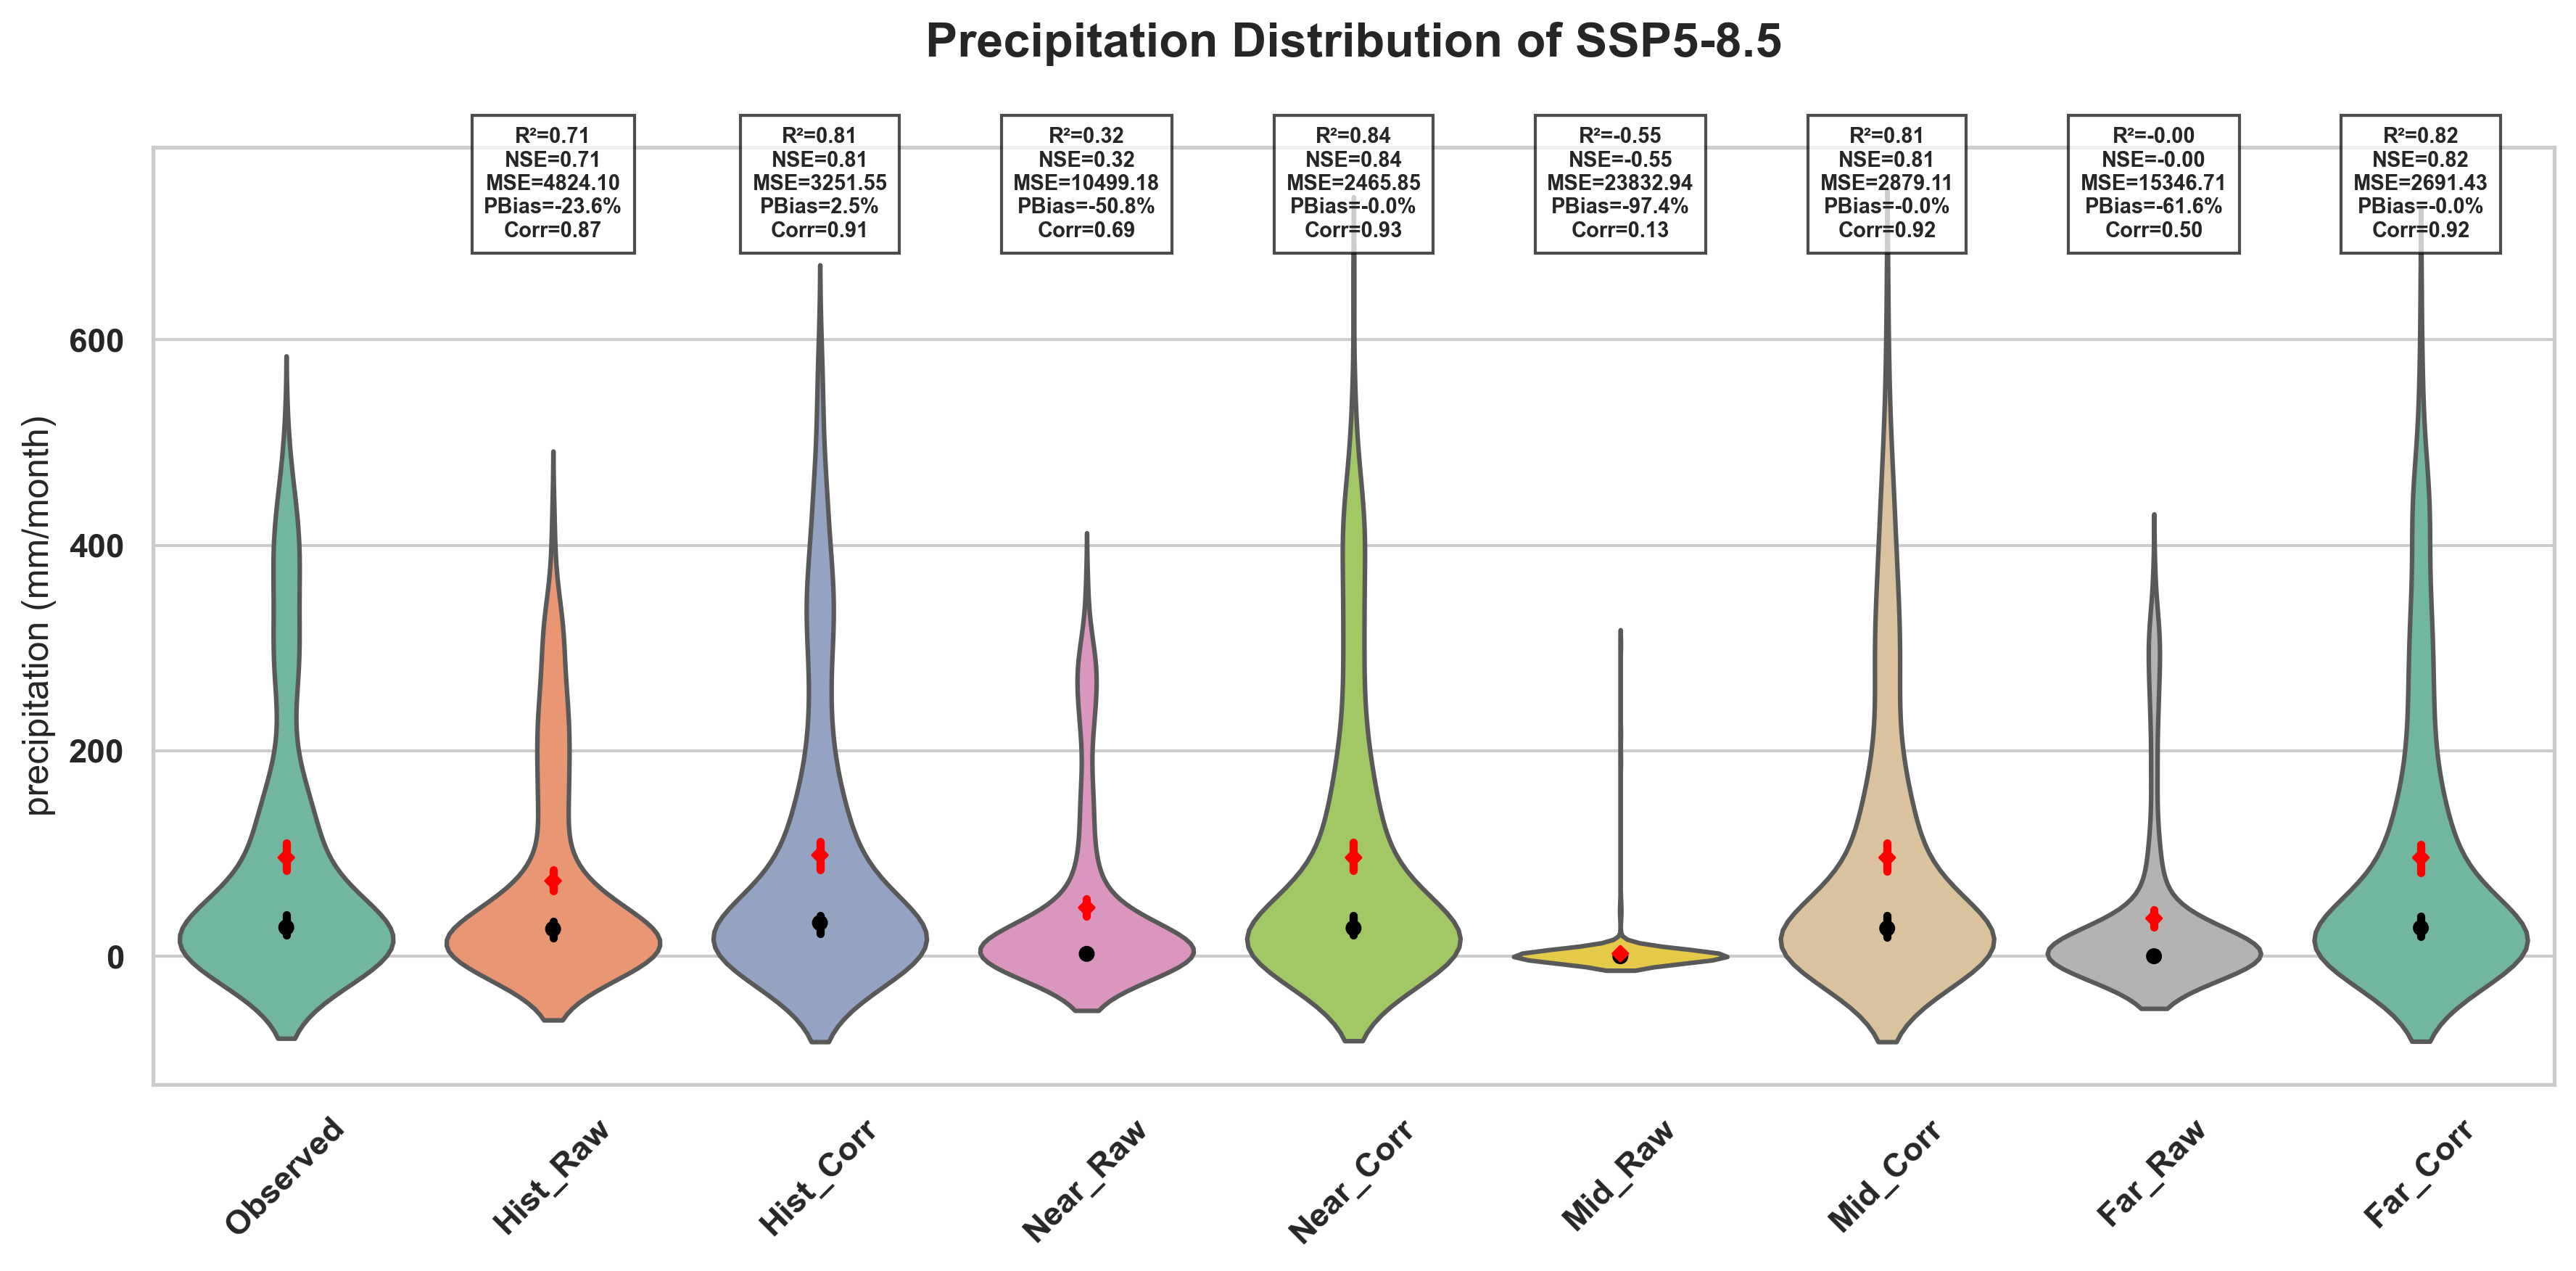

✅ Plot saved to D:\PAU document\Thesis\Analysis\CMIP6 data\MPI_ESM1_2_HR\Future data\SSP58.5\Corrected\precip_ssp585_metrics_violin.jpg


In [113]:
# Slice datasets
for name, (start, end) in periods.items():
    datasets[name] = datasets[name].loc[start:end]

# ======== STATS ========
obs = datasets["Observed"]
stats_df = []
for name, ser in datasets.items():
    if name == "Observed":
        continue
    if "Hist" in name:
        r2, mse, pbias, nse, corr = align_and_stats(obs, ser)
    else:
        r2, mse, pbias, nse, corr = monthly_match_and_stats(obs, ser)
    stats_df.append({
        "Dataset": name,
        "R2": r2, "MSE": mse, "PBIAS": pbias, "NSE": nse, "CORR": corr
    })
stats_df = pd.DataFrame(stats_df)

# ======== LONG DF FOR VIOLIN ========
df_long = pd.concat(datasets, axis=1).melt(var_name="Dataset", value_name="Value").dropna()

# ======== PLOT ========
sns.set(style="whitegrid", font_scale=1)
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

sns.violinplot(
    data=df_long, x="Dataset", y="Value",
    ax=ax, inner=None, scale="width", palette="Set2"
)
sns.pointplot(
    data=df_long, x="Dataset", y="Value",
    ax=ax, join=False, estimator=np.median,
    color="black", markers="o", scale=0.6
)
sns.pointplot(
    data=df_long, x="Dataset", y="Value",
    ax=ax, join=False, estimator=np.mean,
    color="red", markers="D", scale=0.5
)

# Add stats above violins
ymax = df_long["Value"].max()
for i, name in enumerate(df_long["Dataset"].unique()):
    row = stats_df[stats_df["Dataset"] == name]
    if not row.empty:
        s = row.iloc[0]
        text = (
            f"R²={s['R2']:.2f}\n"
            f"NSE={s['NSE']:.2f}\n"
            f"MSE={s['MSE']:.2f}\n"
            f"PBias={s['PBIAS']:.1f}%\n"
            f"Corr={s['CORR']:.2f}"
        )
        ax.text(i, ymax + 0.05*ymax, text,
                ha='center', va='bottom', fontsize=7,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

ax.set_title("Precipitation Distribution of SSP5-8.5", fontsize=16, fontweight='bold', pad=30)
ax.set_xlabel("")
ax.set_ylabel("precipitation (mm/month)")
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(output_jpg, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved to {output_jpg}")